<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>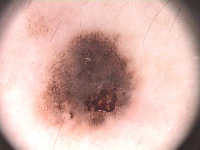</td><td>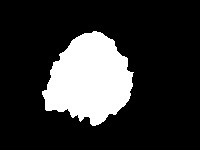</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
! pip install wldhx.yadisk-direct

In [2]:
!curl -L $(yadisk-direct https://disk.yandex.ru/d/PeMrMThIxTVpdw) -o ph2dataset.zip
! unzip -qq ph2dataset.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  202M  100  202M    0     0  12.7M      0  0:00:15  0:00:15 --:--:-- 16.4M
PH2Dataset  ph2dataset.zip  sample_data


Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

# Проверим все ли загрузилось
print(len(images), len(lesions))

200 200


Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')
print(X.shape, Y.shape)

Loaded 200 images
(200, 256, 256, 3) (200, 256, 256)


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

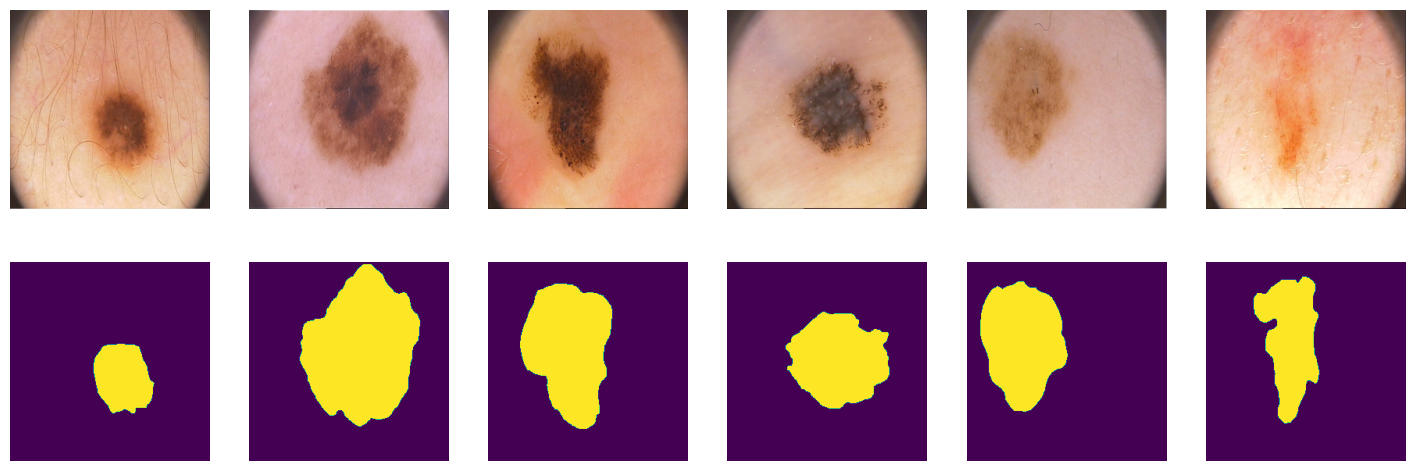

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [7]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [8]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [9]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [10]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

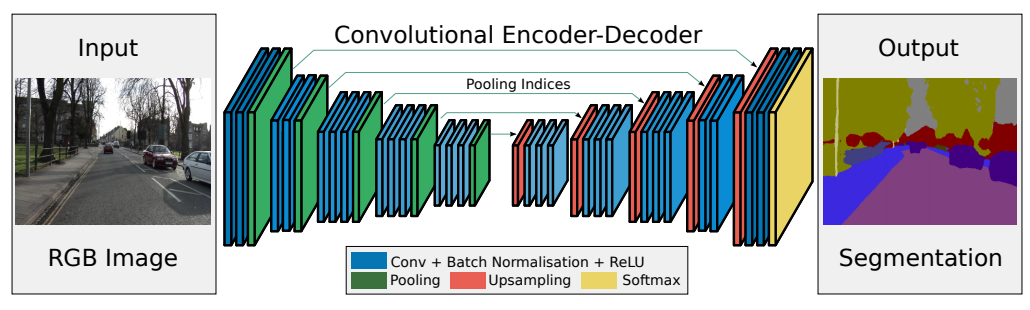

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [30]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
         # 256 -> 128
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
         # 128 -> 64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
         # 64 -> 32
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
        )
         # 32 -> 16
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=1, stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
        )


        # decoder (upsampling)

        # 16 -> 32
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )

        # 32 -> 64
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )

        # 64 -> 128
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1, stride=1),
        )

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [12]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [13]:
def bce_loss(y_real, y_pred):
    return torch.mean((y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))))

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

Объявим score_model для его использования в дальнейшем анализе обучения модели

In [31]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = torch.where(torch.sigmoid(model(X_batch.to(device))) > 0.5, 1, 0)
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    return scores/len(data)

In [15]:
from torch.optim import lr_scheduler

def train(model, opt, loss_fn, epochs, data_tr, data_val):

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_score': [],
        'valid_score': []
    }
    step_lr_scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)
    X_val, Y_val = next(iter(data_val))
    tic = time()

    for epoch in range(epochs):

        print('* Epoch %d/%d' % (epoch+1, epochs))

        train_loss = 0
        model.train()  # train mode

        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            loss =  loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            train_loss += loss / len(data_tr)

        step_lr_scheduler.step()

        history["train_loss"].append(train_loss.item())
        curr_train_score = score_model(model, iou_pytorch, data_tr)
        history["train_score"].append(curr_train_score)
        print('loss: %f' % train_loss)

        # show intermediate results
        # testing mode
        valid_loss = 0
        model.eval()
        with torch.no_grad():
            for X_val, Y_val in data_val:

                X_val = X_val.to(device)
                Y_val = Y_val.to(device)
                Y_pred = model(X_val)
                loss = loss_fn(Y_pred, Y_val)
                valid_loss += loss / len(data_val)

        history["valid_loss"].append(valid_loss.item())
        curr_valid_score = score_model(model, iou_pytorch, data_val)
        history["valid_score"].append(curr_valid_score)


        # detach and put into cpu
        Y_hat = model(X_val.to(device)).detach().cpu()

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].to("cpu").numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, train_loss))
        plt.show()

    # Вычисление затраченного времени
    toc = time()
    elapsed_time = toc - tic
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Время выполнения: {minutes} минут {round(seconds)} секунд")

    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [32]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [33]:
model = SegNet().to(device)

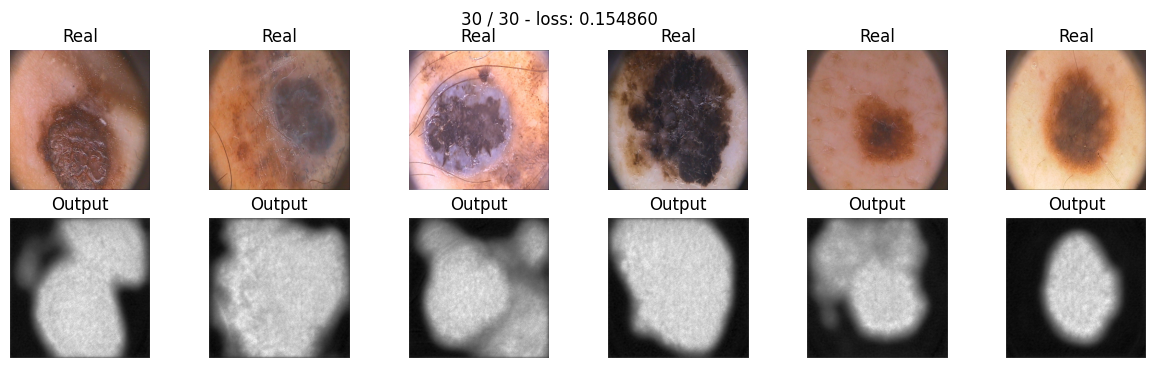

Время выполнения: 3.0 минут 54 секунд


In [39]:
max_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
segnet_history = train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [40]:
score_train = score_model(model, iou_pytorch, data_tr)
score_val = score_model(model, iou_pytorch, data_val)
score_test = score_model(model, iou_pytorch, data_ts)

print(f"Оценка на тренировочной выборке: {score_train}")
print(f"Оценка на валидационной выборке: {score_val}")
print(f"Оценка на тестовой выборке: {score_test}")


Оценка на тренировочной выборке: 0.744000032544136
Оценка на валидационной выборке: 0.6020000278949738
Оценка на тестовой выборке: 0.6399999856948853


In [41]:
import pandas as pd

res = pd.DataFrame(columns=["model", "loss function", "score_train", "score_val", "score_test"])

In [42]:
res.loc[len(res)] = ["SegNet", "BCE", score_train, score_val, score_test]

In [43]:
def show_loss_and_score(history):

    train_loss = history['train_loss']
    valid_loss = history['valid_loss']
    train_score = history['train_score']
    valid_score = history['valid_score']

    epochs = range(1, len(train_loss) + 1)
    fig, axs = plt.subplots(2, 1, figsize=(10, 8))

    axs[0].plot(epochs, train_loss, 'g', label='Training loss')
    axs[0].plot(epochs, valid_loss, 'b', label='Validation loss')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, train_score, 'g', label='Training accuracy')
    axs[1].plot(epochs, valid_score, 'b', label='Validation accuracy')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    fig.tight_layout()
    plt.show()


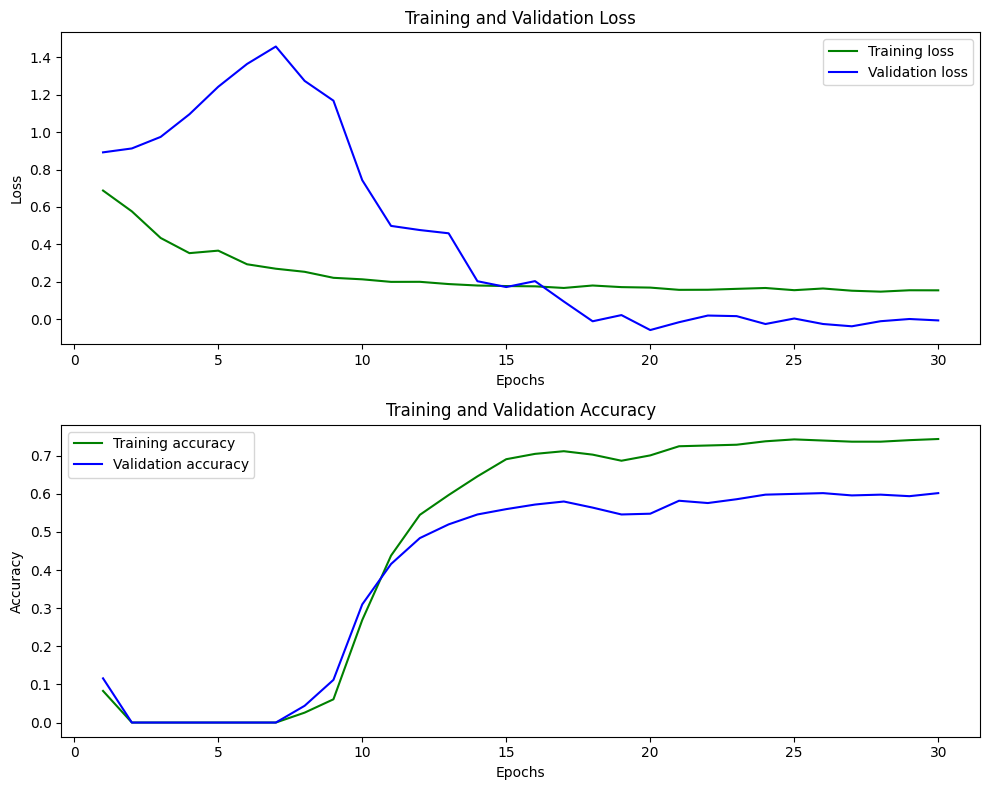

In [44]:
show_loss_and_score(segnet_history)

In [45]:
torch.cuda.empty_cache()

Ответьте себе на вопрос: не переобучается ли моя модель?

Из графиков выше видно, что модель если и переобучается, то незначительно и в определенных эпохах. Скорее именно эта архитектура не совсем подходит под задачу![изображение_2024-04-22_185158903.png](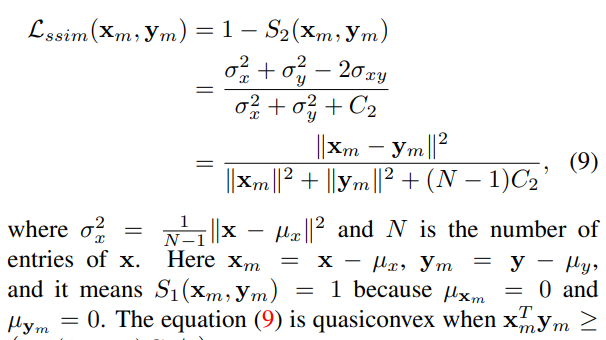![изображение_2024-04-22_185228074.png](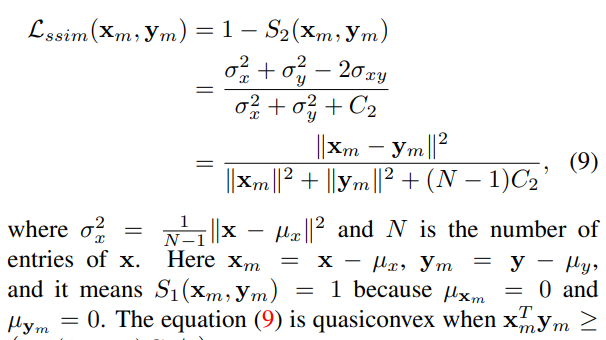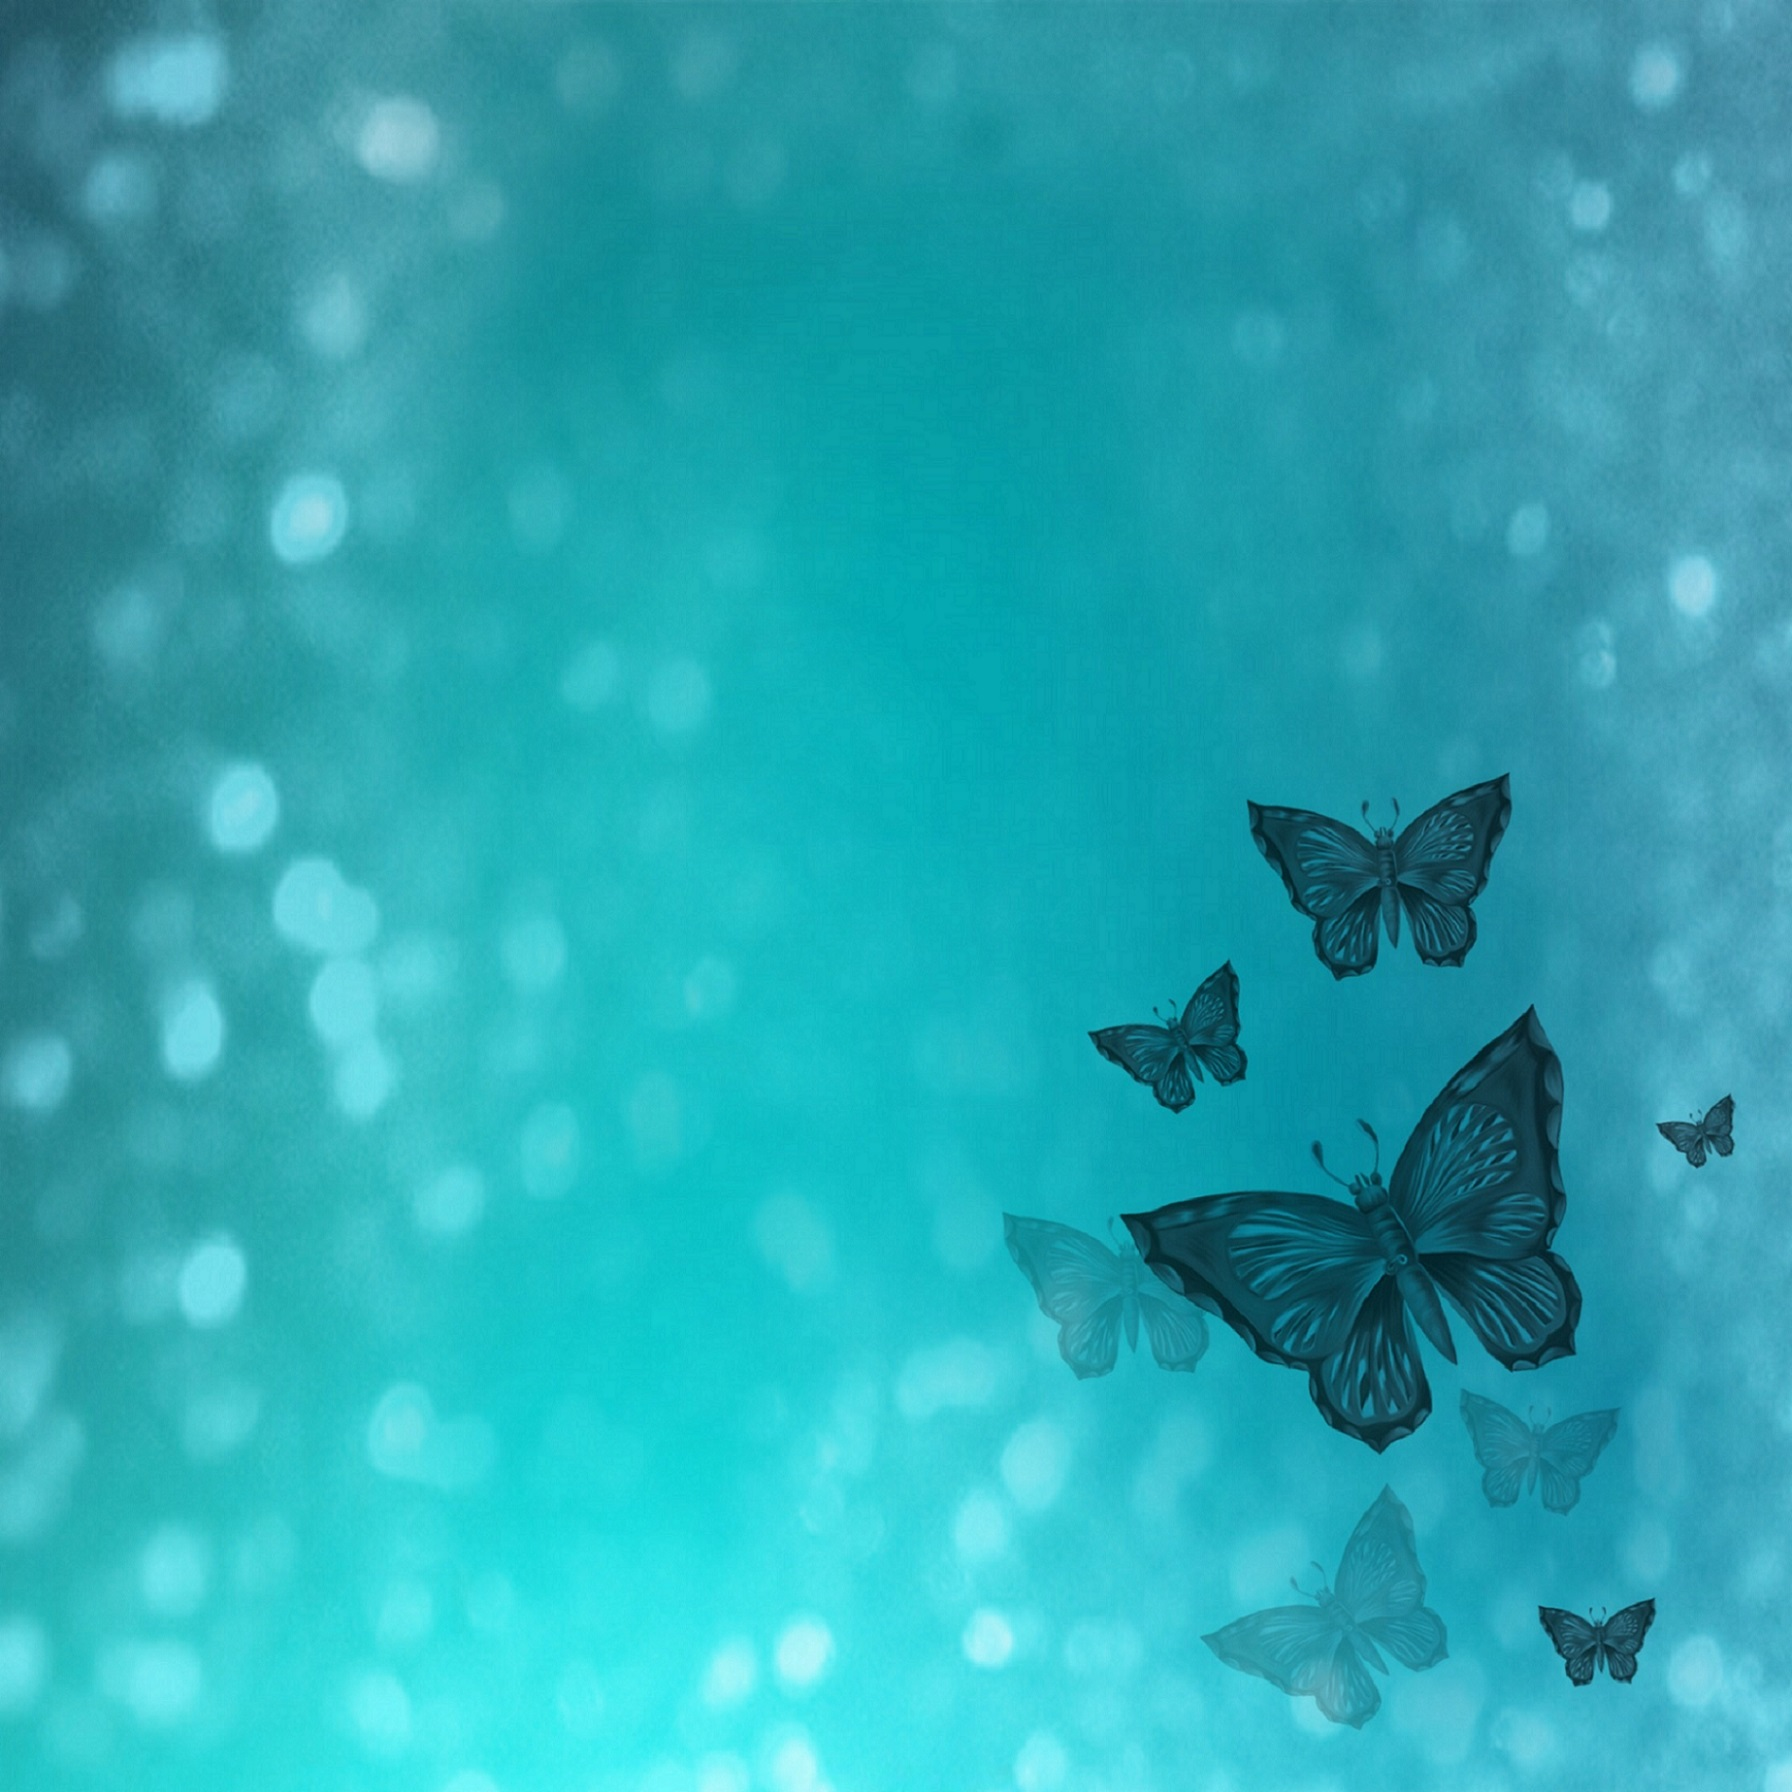)). 20, 30 или 50 эпох значения не имеет - порог score после 15 эпохи колеблется в [0,7; 0,85]. Loss также очень незначительно меняется. Однако помогает подбор параметров в step_lr_scheduler

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [46]:
def dice_loss(y_real, y_pred, smooth=1):
    y_pred = torch.sigmoid(y_pred)
    y_pred = torch.flatten(y_pred)
    y_real = torch.flatten(y_real)

    intersection = (y_pred * y_real).sum()
    dice = (2. * intersection + smooth) / (y_pred.sum() + y_real.sum() + smooth)

    return 1 - dice

Проводим тестирование:

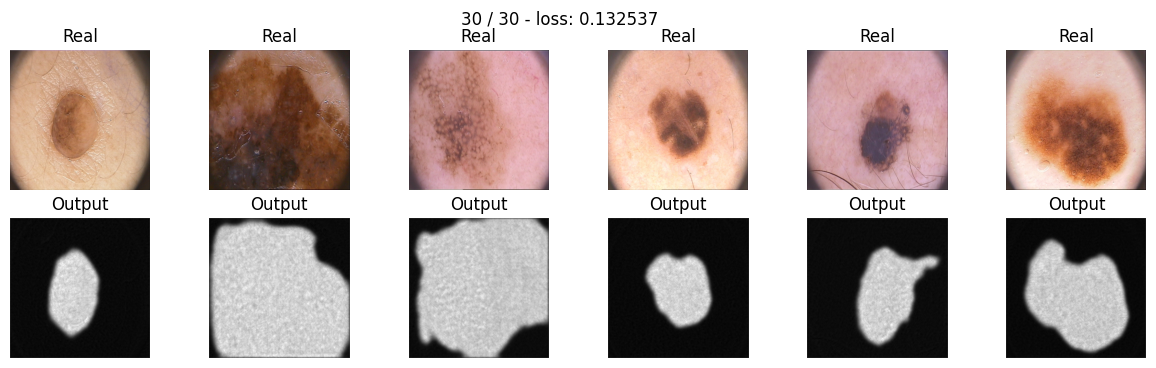

Время выполнения: 3.0 минут 56 секунд


In [47]:
model_dice = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=3e-4)
dice_history = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [48]:
score_train = score_model(model_dice, iou_pytorch, data_tr)
score_val = score_model(model_dice, iou_pytorch, data_val)
score_test = score_model(model_dice, iou_pytorch, data_ts)

print(f"Оценка на тренировочной выборке: {score_train}")
print(f"Оценка на валидационной выборке: {score_val}")
print(f"Оценка на тестовой выборке: {score_test}")

Оценка на тренировочной выборке: 0.792000025510788
Оценка на валидационной выборке: 0.6140000224113464
Оценка на тестовой выборке: 0.6759999692440033


In [49]:
res.loc[len(res)] = ["SegNet", "DICE", score_train, score_val, score_test]

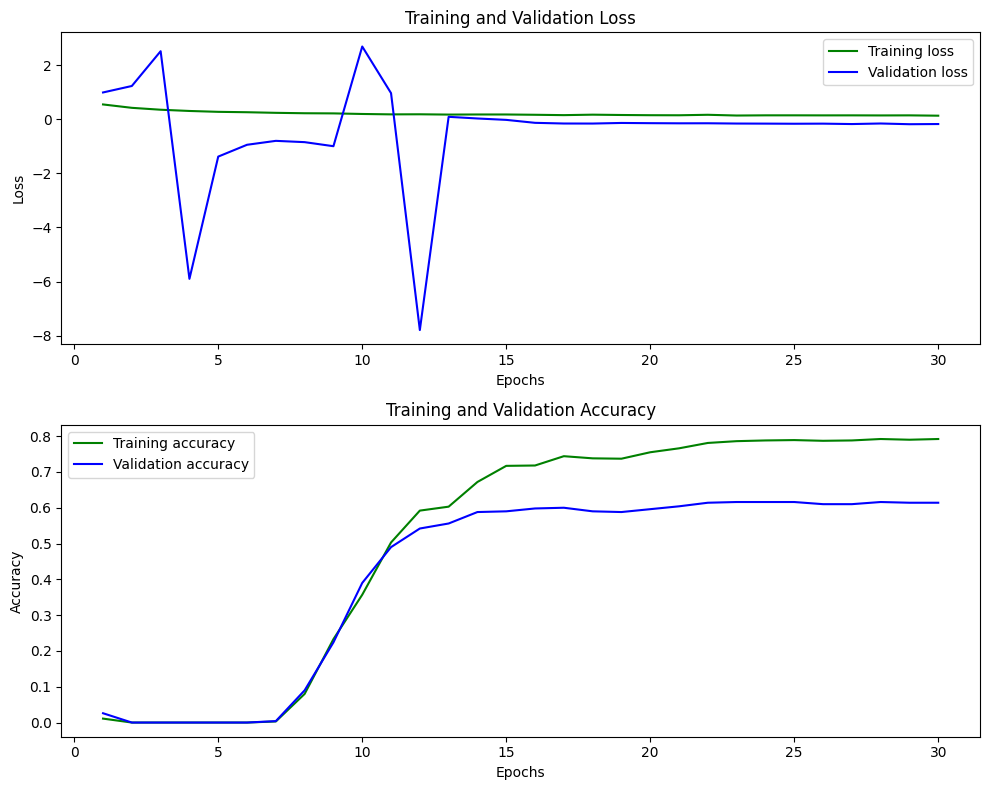

In [50]:
show_loss_and_score(dice_history)

In [51]:
torch.cuda.empty_cache()

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [52]:
def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
    s = torch.clamp(torch.sigmoid(y_pred), eps, 1 - eps)
    loss = -((1-s)**gamma*y_real*s.log() + s**gamma*(1-y_real)*(1-s).log())
    return loss.mean()



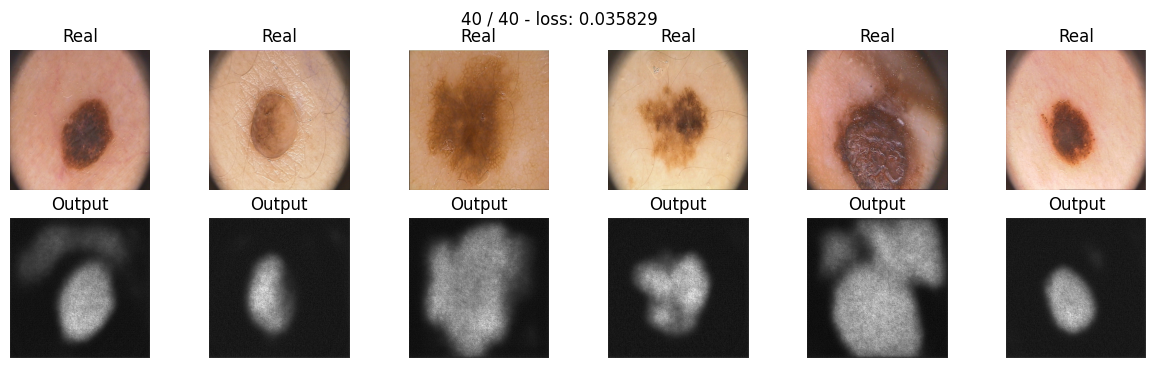

Время выполнения: 5.0 минут 24 секунд


In [53]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=3e-4)
focal_history = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [54]:
score_train = score_model(model_focal, iou_pytorch, data_tr)
score_val = score_model(model_focal, iou_pytorch, data_val)
score_test = score_model(model_focal, iou_pytorch, data_ts)

print(f"Оценка на тренировочной выборке: {score_train}")
print(f"Оценка на валидационной выборке: {score_val}")
print(f"Оценка на тестовой выборке: {score_test}")

Оценка на тренировочной выборке: 0.8400000184774399
Оценка на валидационной выборке: 0.6259999871253967
Оценка на тестовой выборке: 0.6919999718666077


In [55]:
res.loc[len(res)] = ["SegNet", "Focal", score_train, score_val, score_test]

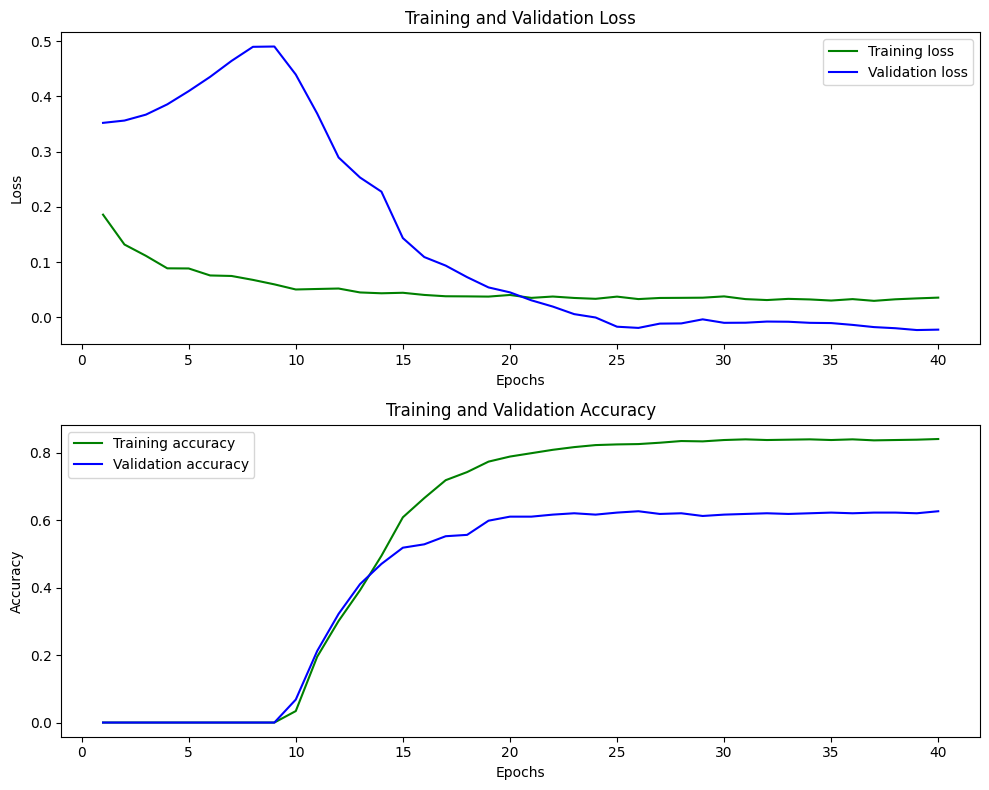

In [56]:
show_loss_and_score(focal_history)

In [57]:
torch.cuda.empty_cache()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Взял в качестве бонусного SSIM [отсюда](https://arxiv.org/abs/1910.08711)

Structural Similarity Loss - это метод оценки качества семантической сегментации, который учитывает структурную сходство между исходным изображением и выходом сети. Он не так распространен, как Cross-Entropy Loss или Dice Loss. Однако, с увеличением исследований в области глубокого обучения и семантической сегментации, новые методы потерь, такие как CMSS Loss, могут привлечь внимание из-за своей способности учитывать структурное сходство между изображениями

Вырезка всё из той же статьи

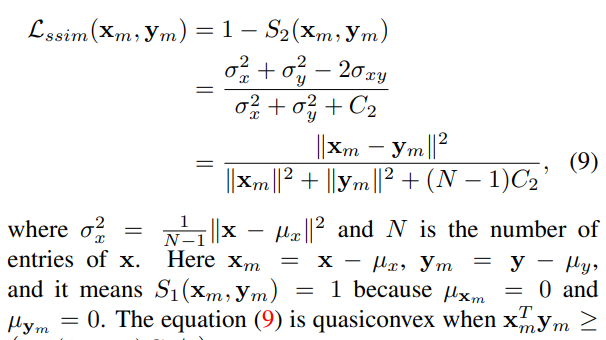

In [58]:
def ssim_loss(y_pred, y_real):
    y_real = torch.flatten(y_real)
    y_pred = torch.flatten(y_pred)

    # В статье сказано, что это значение константы более стабильное (но это не точно)
    c2 = 1e-3

    y_real = y_real - torch.mean(y_real)
    y_pred = y_pred - torch.mean(y_pred)
    loss = ((y_real - y_pred) ** 2) / (y_real ** 2 + y_pred ** 2 + (len(y_real) - 1) * c2)
    return torch.mean(loss)

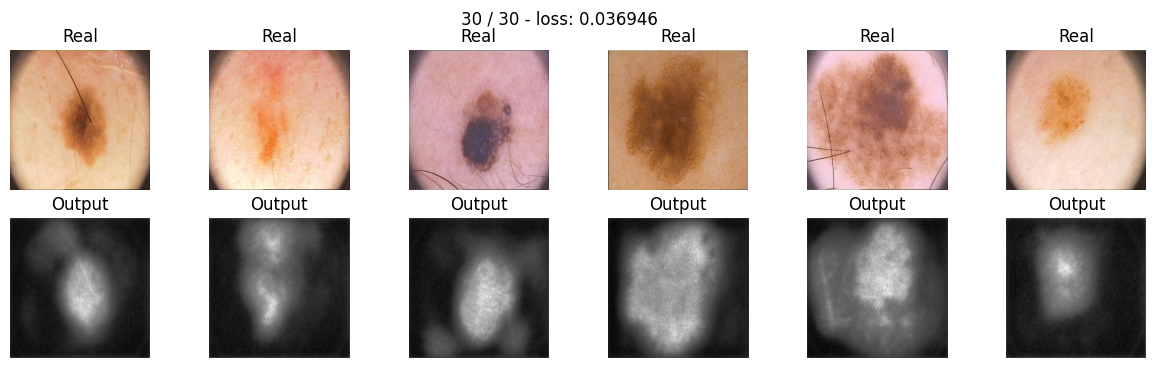

Время выполнения: 3.0 минут 55 секунд


In [74]:
model_ssim = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_ssim.parameters(), lr=3e-4)
ssim_history = train(model_ssim, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [76]:
score_train = score_model(model_ssim, iou_pytorch, data_tr)
score_val = score_model(model_ssim, iou_pytorch, data_val)
score_test = score_model(model_ssim, iou_pytorch, data_ts)

print(f"Оценка на тренировочной выборке: {score_train}")
print(f"Оценка на валидационной выборке: {score_val}")
print(f"Оценка на тестовой выборке: {score_test}")

Оценка на тренировочной выборке: 0.7339999675750732
Оценка на валидационной выборке: 0.6159999668598175
Оценка на тестовой выборке: 0.6220000088214874


In [77]:
res.loc[3] = ["SegNet", "SSIM", score_train, score_val, score_test]

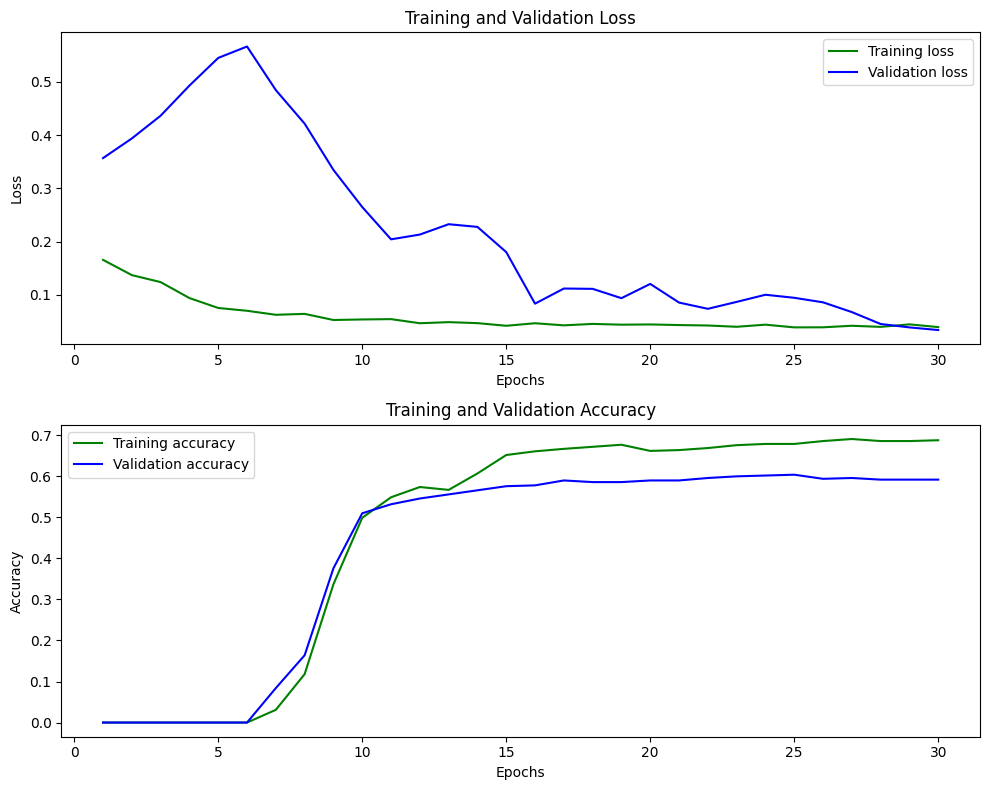

In [62]:
show_loss_and_score(ssim_history)

In [63]:
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

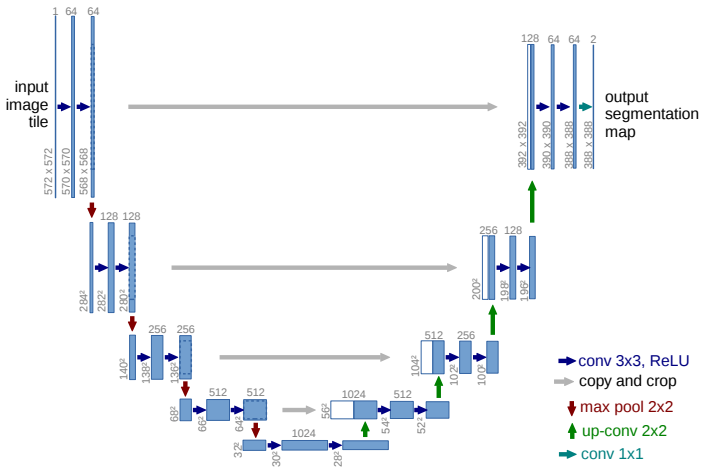

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

Возьмем за основу предыдущий SegNet и добавим skip connections

In [20]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode="nearest") # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.Upsample(scale_factor=2, mode="nearest") # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.Upsample(scale_factor=2, mode="nearest")  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.Upsample(scale_factor=2, mode="nearest")  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool = self.pool0(e0)

        e1 = self.enc_conv1(e0_pool)
        e1_pool = self.pool1(e1)

        e2 = self.enc_conv2(e1_pool)
        e2_pool = self.pool2(e2)

        e3 = self.enc_conv3(e2_pool)
        e3_pool = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_pool)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))

        return d3

In [21]:
unet_model = UNet().to(device)

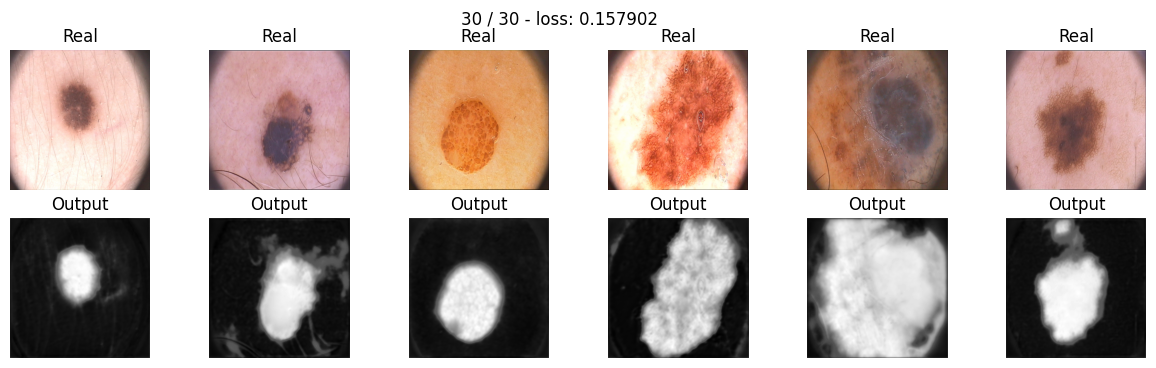

Время выполнения: 4.0 минут 35 секунд


In [79]:
unet_history = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=3e-4), bce_loss, 30, data_tr, data_val)

In [80]:
score_train = score_model(unet_model, iou_pytorch, data_tr)
score_val = score_model(unet_model, iou_pytorch, data_val)
score_test = score_model(unet_model, iou_pytorch, data_ts)

print(f"Оценка на тренировочной выборке: {score_train}")
print(f"Оценка на валидационной выборке: {score_val}")
print(f"Оценка на тестовой выборке: {score_test}")

Оценка на тренировочной выборке: 0.828000009059906
Оценка на валидационной выборке: 0.6539999842643738
Оценка на тестовой выборке: 0.7219999730587006


In [81]:
res.loc[4] = ["UNet", "BCE", score_train, score_val, score_test]

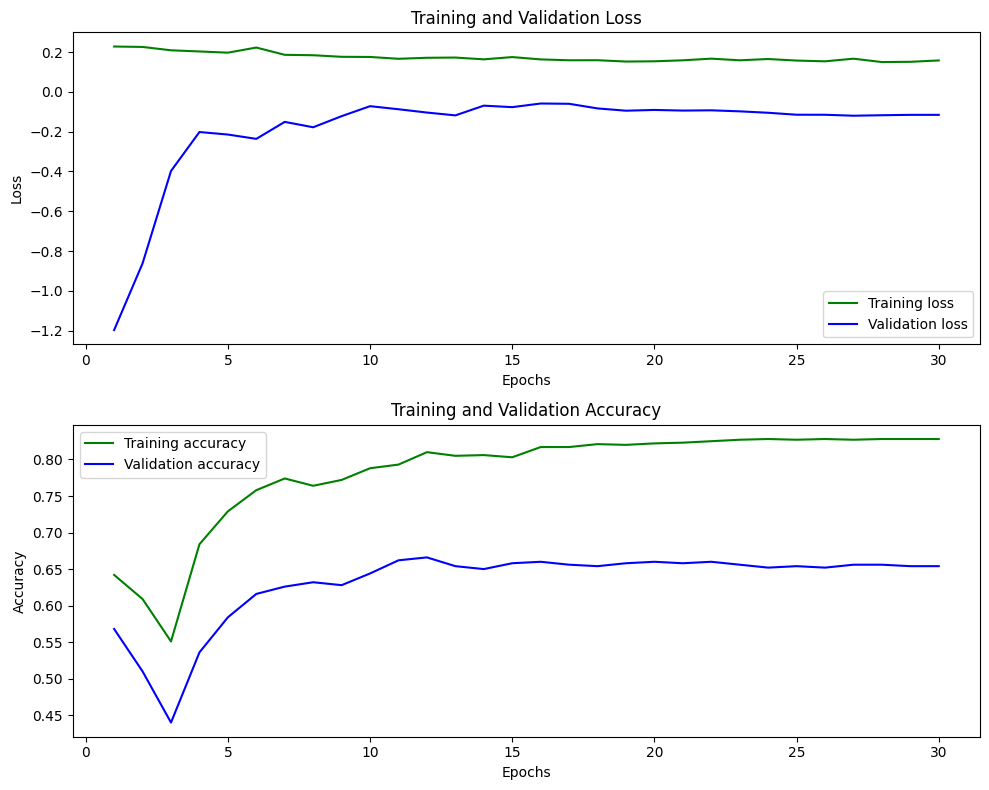

In [82]:
show_loss_and_score(unet_history)

In [67]:
torch.cuda.empty_cache()

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [24]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool = self.pool0(e0)

        e1 = self.enc_conv1(e0_pool)
        e1_pool = self.pool1(e1)

        e2 = self.enc_conv2(e1_pool)
        e2_pool = self.pool2(e2)

        e3 = self.enc_conv3(e2_pool)
        e3_pool = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_pool)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))

        return d3

In [25]:
unet2_model = UNet2().to(device)


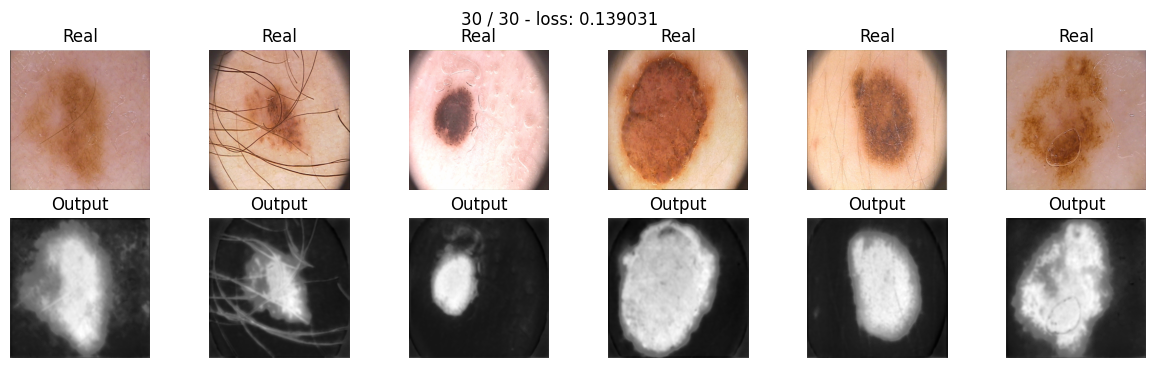

Время выполнения: 5.0 минут 14 секунд


In [83]:
unet2_history = train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=3e-4), bce_loss, 30, data_tr, data_val)

In [84]:
score_train = score_model(unet2_model, iou_pytorch, data_tr)
score_val = score_model(unet2_model, iou_pytorch, data_val)
score_test = score_model(unet2_model, iou_pytorch, data_ts)

print(f"Оценка на тренировочной выборке: {score_train}")
print(f"Оценка на валидационной выборке: {score_val}")
print(f"Оценка на тестовой выборке: {score_test}")

Оценка на тренировочной выборке: 0.7850000262260437
Оценка на валидационной выборке: 0.6260000169277191
Оценка на тестовой выборке: 0.6539999842643738


In [85]:
res.loc[5] = ["UNet2", "BCE", score_train, score_val, score_test]

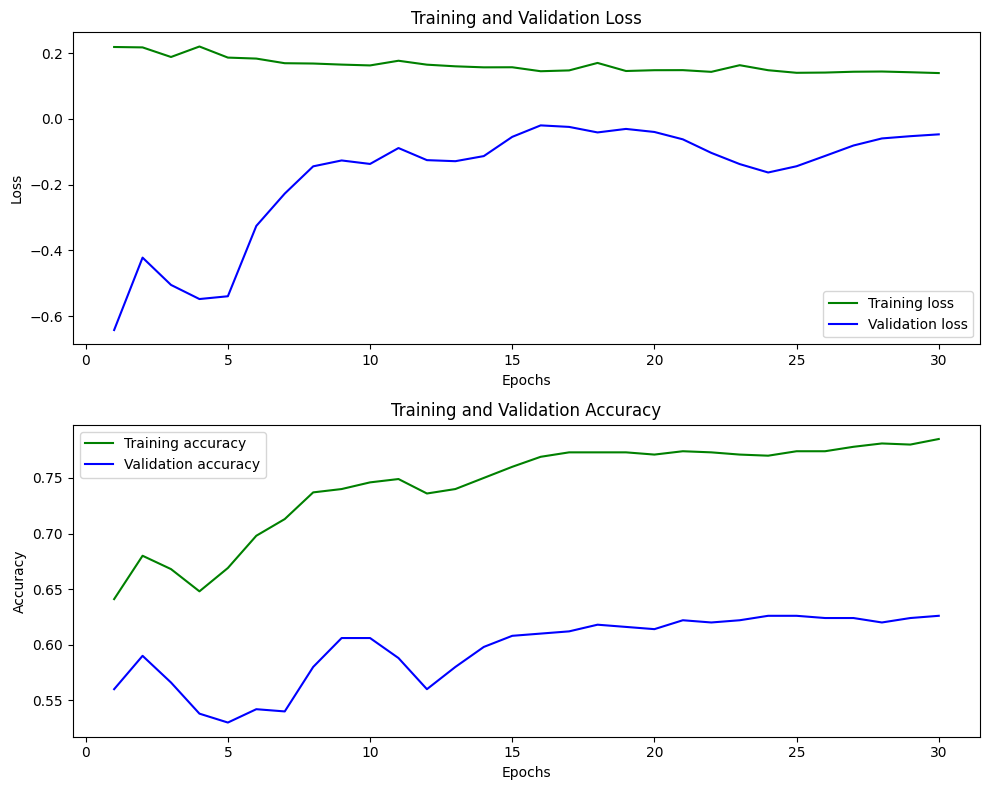

In [86]:
show_loss_and_score(unet2_history)

In [ ]:
torch.cuda.empty_cache()

Сделайте вывод, какая из моделей лучше

In [88]:
display(res)

model loss function  score_train  score_val  score_test
0  SegNet           BCE        0.744      0.602       0.640
1  SegNet          DICE        0.792      0.614       0.676
2  SegNet         Focal        0.840      0.626       0.692
3  SegNet          SSIM        0.734      0.616       0.622
4    UNet           BCE        0.828      0.654       0.722
5   UNet2           BCE        0.785      0.626       0.654

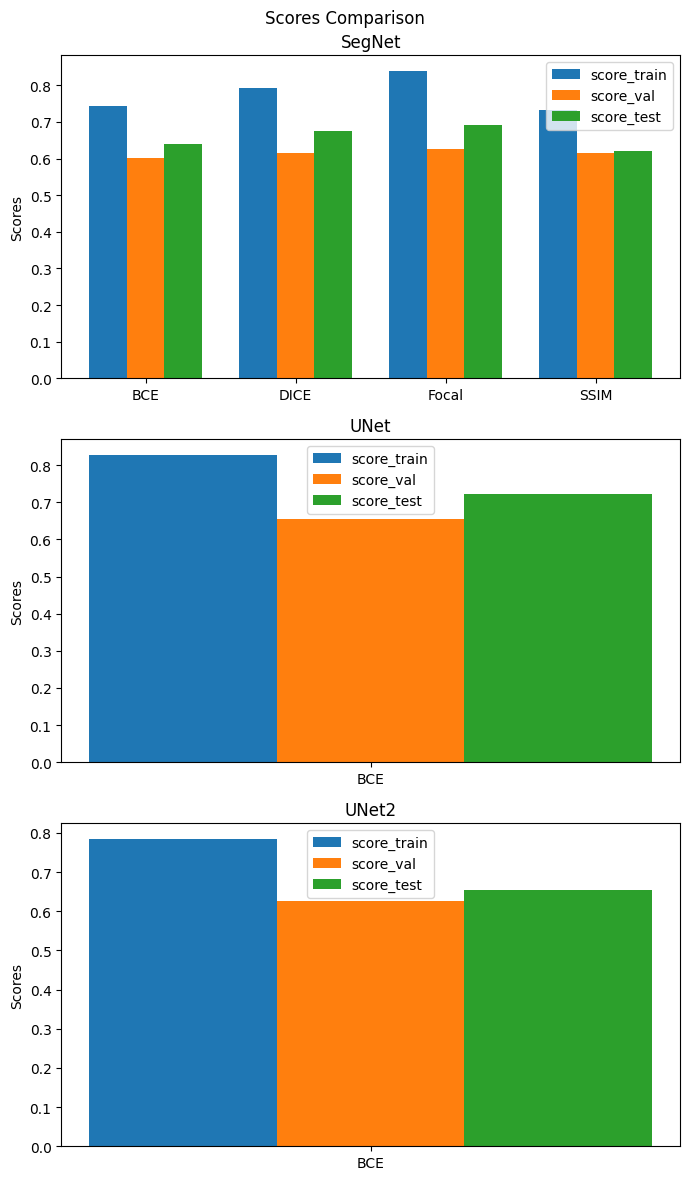

In [110]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, figsize=(7, 12))

segnet_scores = res[res["model"] == "SegNet"]
labels = list(segnet_scores["loss function"])
score_train = list(segnet_scores["score_train"])
score_val = list(segnet_scores["score_val"])
score_test = list(segnet_scores["score_test"])

x = np.arange(len(labels))
width = 0.25

axs[0].bar(x, score_train, width, label="score_train")
axs[0].bar(x + width, score_val, width, label="score_val")
axs[0].bar(x + width * 2, score_test, width, label="score_test")

axs[0].set_ylabel("Scores")
axs[0].set_title("SegNet")
axs[0].set_xticks(x + width)
axs[0].set_xticklabels(labels)
axs[0].legend(loc="best")

unet_scores = res[res["model"] == "UNet"]
labels = list(unet_scores["loss function"])
score_train = list(unet_scores["score_train"])
score_val = list(unet_scores["score_val"])
score_test = list(unet_scores["score_test"])

x = np.arange(len(labels))
width = 0.25

axs[1].bar(x, score_train, width, label="score_train")
axs[1].bar(x + width, score_val, width, label="score_val")
axs[1].bar(x + width * 2, score_test, width, label="score_test")

axs[1].set_ylabel("Scores")
axs[1].set_title("UNet")
axs[1].set_xticks(x + width)
axs[1].set_xticklabels(labels)
axs[1].legend(loc="best")

unet2_scores = res[res["model"] == "UNet2"]
labels = list(unet2_scores["loss function"])
score_train = list(unet2_scores["score_train"])
score_val = list(unet2_scores["score_val"])
score_test = list(unet2_scores["score_test"])

x = np.arange(len(labels))
width = 0.25

axs[2].bar(x, score_train, width, label="score_train")
axs[2].bar(x + width, score_val, width, label="score_val")
axs[2].bar(x + width * 2, score_test, width, label="score_test")

axs[2].set_ylabel("Scores")
axs[2].set_title("UNet2")
axs[2].set_xticks(x + width)
axs[2].set_xticklabels(labels)
axs[2].legend(loc="best")


fig.suptitle("Scores Comparison")


fig.tight_layout()


plt.show()


Сложно делать объёмные выводы за час до дедлайна, но если попытаться резюмировать то:

Очень хорошо себя показывают DICE и Focal лоссы даже на SegNet. Уверен, что и на UNet при настройке lr, scheduler они показали бы отличный результат. Более того даже если увеличивать эпохи (до 50 - 70) не будет переобучения.

Похоже есть некая проблема затухания градиентов, что отчасти помогает решить Skip Connections

Думаю по этой причине Unet BCE показывает лучший скор


In [92]:
res.nlargest(1, "score_test")

model loss function  score_train  score_val  score_test
4  UNet           BCE        0.828      0.654       0.722